In [1]:
import torch
import torchvision
import argparse


import torch.nn as nn
import functools
from torch.autograd import Variable
import os
import cv2
import random

import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import random

import tqdm

import matplotlib.pyplot as plt


from __future__ import print_function
import torch
import numpy as np
from PIL import Image
import numpy as np
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')

# python train.py --name face --resize_or_crop resize_and_crop --loadSize 563 --fineSize 512 --label_nc 0 --no_instance --dataroot ../datasets/pix2pix/face

Using: cuda


In [2]:
# Converts a Tensor into a Numpy array
# |imtype|: the desired type of the converted numpy array
def tensor2im(image_tensor, imtype=np.uint8, normalize=True):
    if isinstance(image_tensor, list):
        image_numpy = []
        for i in range(len(image_tensor)):
            image_numpy.append(tensor2im(image_tensor[i], imtype, normalize))
        return image_numpy
    image_numpy = image_tensor.cpu().float().numpy()
    if normalize:
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0      
    image_numpy = np.clip(image_numpy, 0, 255)
    if image_numpy.shape[2] == 1 or image_numpy.shape[2] > 3:        
        image_numpy = image_numpy[:,:,0]
    return image_numpy.astype(imtype)

# Converts a one-hot tensor into a colorful label map
def tensor2label(label_tensor, n_label, imtype=np.uint8):
    if n_label == 0:
        return tensor2im(label_tensor, imtype)
    label_tensor = label_tensor.cpu().float()    
    if label_tensor.size()[0] > 1:
        label_tensor = label_tensor.max(0, keepdim=True)[1]
    label_tensor = Colorize(n_label)(label_tensor)
    label_numpy = np.transpose(label_tensor.numpy(), (1, 2, 0))
    return label_numpy.astype(imtype)

def save_image(image_numpy, image_path):
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(image_path)

def mkdirs(paths):
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

###############################################################################
# Code from
# https://github.com/ycszen/pytorch-seg/blob/master/transform.py
# Modified so it complies with the Citscape label map colors
###############################################################################
def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])

def labelcolormap(N):
    if N == 35: # cityscape
        cmap = np.array([(  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (111, 74,  0), ( 81,  0, 81),
                     (128, 64,128), (244, 35,232), (250,170,160), (230,150,140), ( 70, 70, 70), (102,102,156), (190,153,153),
                     (180,165,180), (150,100,100), (150,120, 90), (153,153,153), (153,153,153), (250,170, 30), (220,220,  0),
                     (107,142, 35), (152,251,152), ( 70,130,180), (220, 20, 60), (255,  0,  0), (  0,  0,142), (  0,  0, 70),
                     (  0, 60,100), (  0,  0, 90), (  0,  0,110), (  0, 80,100), (  0,  0,230), (119, 11, 32), (  0,  0,142)], 
                     dtype=np.uint8)
    else:
        cmap = np.zeros((N, 3), dtype=np.uint8)
        for i in range(N):
            r, g, b = 0, 0, 0
            id = i
            for j in range(7):
                str_id = uint82bin(id)
                r = r ^ (np.uint8(str_id[-1]) << (7-j))
                g = g ^ (np.uint8(str_id[-2]) << (7-j))
                b = b ^ (np.uint8(str_id[-3]) << (7-j))
                id = id >> 3
            cmap[i, 0] = r
            cmap[i, 1] = g
            cmap[i, 2] = b
    return cmap

class Colorize(object):
    def __init__(self, n=35):
        self.cmap = labelcolormap(n)
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        color_image = torch.ByteTensor(3, size[1], size[2]).fill_(0)

        for label in range(0, len(self.cmap)):
            mask = (label == gray_image[0]).cpu()
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 4

In [4]:
class BaseDataset(data.Dataset):
    def __init__(self):
        super(BaseDataset, self).__init__()

    def name(self):
        return 'BaseDataset'

    def initialize(self):
        pass

def get_params(size):
    w, h = size
    new_h = h
    new_w = w
    resize_or_crop = 'resize_and_crop'
    loadSize = IMAGE_SIZE
    fineSize = IMAGE_SIZE

    
    if resize_or_crop == 'resize_and_crop':
        new_h = new_w = loadSize            
    elif resize_or_crop == 'scale_width_and_crop':
        new_w = loadSize
        new_h = loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - fineSize))
    y = random.randint(0, np.maximum(0, new_h - fineSize))
    
    flip = random.random() > 0.5
    return {'crop_pos': (x, y), 'flip': flip}

def get_transform(params, method=Image.BICUBIC, normalize=True):
    transform_list = []

    resize_or_crop = 'resize_and_crop'
    loadSize = IMAGE_SIZE
    fineSize = IMAGE_SIZE
    
    if 'resize' in resize_or_crop:
        osize = [loadSize, loadSize]
        transform_list.append(transforms.Resize(osize, method))   
    elif 'scale_width' in resize_or_crop:
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, loadSize, method)))
        
    if 'crop' in resize_or_crop:
        transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], fineSize)))

    if resize_or_crop == 'none':
        #base = float(2 ** opt.n_downsample_global)
        base = float(2 ** 4)
        #if opt.netG == 'local':
        if 'global' == 'local':
            #base *= (2 ** opt.n_local_enhancers)
            base *= (2 ** 1)
        transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base, method)))

    if False and not False:
        transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

    transform_list += [transforms.ToTensor()]

    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

def normalize():    
    return transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

def __make_power_2(img, base, method=Image.BICUBIC):
    ow, oh = img.size        
    h = int(round(oh / base) * base)
    w = int(round(ow / base) * base)
    if (h == oh) and (w == ow):
        return img
    return img.resize((w, h), method)

def __scale_width(img, target_width, method=Image.BICUBIC):
    ow, oh = img.size
    if (ow == target_width):
        return img    
    w = target_width
    h = int(target_width * oh / ow)    
    return img.resize((w, h), method)

def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):        
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img

def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img


In [5]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src1: str, src2: str):
        self.src1=src1
        self.src2=src2

        self.labels=os.listdir(src1)
        self.images=os.listdir(src2)

        #self.transform=torchvision.transforms.Compose([torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))])

    
    def __len__(self):
        return len(self.labels)


    def apply_mosaic(self,image, top_left_x, top_left_y, width, height, mosaic_size):
        roi = image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
        roi_small = cv2.resize(roi, (mosaic_size, mosaic_size), interpolation=cv2.INTER_LINEAR)
        mosaic = cv2.resize(roi_small, (width, height), interpolation=cv2.INTER_NEAREST)
        image[top_left_y:top_left_y+height, top_left_x:top_left_x+width] = mosaic
        return image


    def __getitem__(self,idx: int):
        label=self.src1+'/'+self.labels[idx]
        image=self.src2+'/'+self.images[idx]

        img_height, img_width = (IMAGE_SIZE,IMAGE_SIZE)

        mosaic_width = random.randint(50,200)
        mosaic_height = random.randint(50,200)
        mosaic_size = random.randint(5,10)  # Size of each mosaic block
        
        top_left_x = random.randint(0, img_width - mosaic_width)
        top_left_y = random.randint(0, img_height - mosaic_height)
        
        # Apply the mosaic effect

        original = cv2.imread(label)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        A = Image.fromarray(np.copy(original))
        
        B = Image.fromarray(self.apply_mosaic(original, top_left_x, top_left_y, mosaic_width, mosaic_height, mosaic_size))
        
        params = get_params(A.size)
        
        transform_A = get_transform(params)
        A_tensor = transform_A(A)

        B_tensor = inst_tensor = feat_tensor = 0
        
        ### input B (real images)
        #B = Image.open(image).convert('RGB')
        transform_B = get_transform(params)      
        B_tensor = transform_B(B)

        
        #input_dict = {'label': A_tensor, 'inst': inst_tensor, 'image': B_tensor, 
        #              'feat': feat_tensor, 'path': A_path}

        return A_tensor, B_tensor

In [6]:
train_ds=dataset('../food-101/images/tuna_ds/train_A/','../food-101/images/tuna_ds/train_B/')
val_ds=dataset('../food-101/images/waffles_ds/train_A/','../food-101/images/waffles_ds/train_B/')

train_dl=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_dl=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)

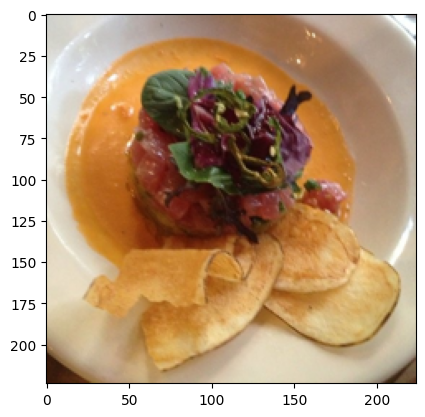

In [7]:
plt.imshow(tensor2im(train_ds[10][0]))

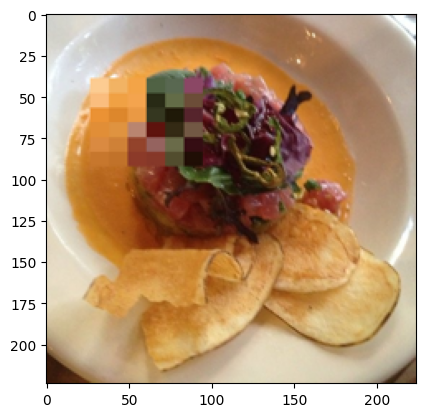

In [8]:
plt.imshow(tensor2im(train_ds[10][1]))

In [9]:
class BaseOptions():
    def __init__(self):
        self.parser = argparse.ArgumentParser()
        self.initialized = False

    def initialize(self):    
        # experiment specifics
        self.parser.add_argument('--name', type=str, default='label2city', help='name of the experiment. It decides where to store samples and models')        
        self.parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        self.parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
        self.parser.add_argument('--model', type=str, default='pix2pixHD', help='which model to use')
        self.parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization')        
        self.parser.add_argument('--use_dropout', action='store_true', help='use dropout for the generator')
        self.parser.add_argument('--data_type', default=32, type=int, choices=[8, 16, 32], help="Supported data type i.e. 8, 16, 32 bit")
        self.parser.add_argument('--verbose', action='store_true', default=False, help='toggles verbose')
        self.parser.add_argument('--fp16', action='store_true', default=False, help='train with AMP')
        self.parser.add_argument('--local_rank', type=int, default=0, help='local rank for distributed training')

        # input/output sizes       
        self.parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
        self.parser.add_argument('--loadSize', type=int, default=1024, help='scale images to this size')
        self.parser.add_argument('--fineSize', type=int, default=512, help='then crop to this size')
        self.parser.add_argument('--label_nc', type=int, default=35, help='# of input label channels')
        self.parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels')
        self.parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels')

        # for setting inputs
        self.parser.add_argument('--dataroot', type=str, default='./datasets/cityscapes/') 
        self.parser.add_argument('--resize_or_crop', type=str, default='scale_width', help='scaling and cropping of images at load time [resize_and_crop|crop|scale_width|scale_width_and_crop]')
        self.parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')        
        self.parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data argumentation') 
        self.parser.add_argument('--nThreads', default=2, type=int, help='# threads for loading data')                
        self.parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')

        # for displays
        self.parser.add_argument('--display_winsize', type=int, default=512,  help='display window size')
        self.parser.add_argument('--tf_log', action='store_true', help='if specified, use tensorboard logging. Requires tensorflow installed')

        # for generator
        self.parser.add_argument('--netG', type=str, default='global', help='selects model to use for netG')
        self.parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in first conv layer')
        self.parser.add_argument('--n_downsample_global', type=int, default=4, help='number of downsampling layers in netG') 
        self.parser.add_argument('--n_blocks_global', type=int, default=9, help='number of residual blocks in the global generator network')
        self.parser.add_argument('--n_blocks_local', type=int, default=3, help='number of residual blocks in the local enhancer network')
        self.parser.add_argument('--n_local_enhancers', type=int, default=1, help='number of local enhancers to use')        
        self.parser.add_argument('--niter_fix_global', type=int, default=0, help='number of epochs that we only train the outmost local enhancer')        

        # for instance-wise features
        self.parser.add_argument('--no_instance', action='store_true', help='if specified, do *not* add instance map as input')        
        self.parser.add_argument('--instance_feat', action='store_true', help='if specified, add encoded instance features as input')
        self.parser.add_argument('--label_feat', action='store_true', help='if specified, add encoded label features as input')        
        self.parser.add_argument('--feat_num', type=int, default=3, help='vector length for encoded features')        
        self.parser.add_argument('--load_features', action='store_true', help='if specified, load precomputed feature maps')
        self.parser.add_argument('--n_downsample_E', type=int, default=4, help='# of downsampling layers in encoder') 
        self.parser.add_argument('--nef', type=int, default=16, help='# of encoder filters in the first conv layer')        
        self.parser.add_argument('--n_clusters', type=int, default=10, help='number of clusters for features')        

        self.initialized = True

    def parse(self, save=True):
        if not self.initialized:
            self.initialize()
        self.opt = self.parser.parse_args()
        self.opt.isTrain = self.isTrain   # train or test

        str_ids = self.opt.gpu_ids.split(',')
        self.opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                self.opt.gpu_ids.append(id)
        
        # set gpu ids
        if len(self.opt.gpu_ids) > 0:
            torch.cuda.set_device(self.opt.gpu_ids[0])

        args = vars(self.opt)

        print('------------ Options -------------')
        for k, v in sorted(args.items()):
            print('%s: %s' % (str(k), str(v)))
        print('-------------- End ----------------')

        # save to the disk        
        expr_dir = os.path.join(self.opt.checkpoints_dir, 'depixie')
        util.mkdirs(expr_dir)
        if save and not self.opt.continue_train:
            file_name = os.path.join(expr_dir, 'opt.txt')
            with open(file_name, 'wt') as opt_file:
                opt_file.write('------------ Options -------------\n')
                for k, v in sorted(args.items()):
                    opt_file.write('%s: %s\n' % (str(k), str(v)))
                opt_file.write('-------------- End ----------------\n')
        return self.opt


class TrainOptions(BaseOptions):
    def initialize(self):
        BaseOptions.initialize(self)
        # for displays
        self.parser.add_argument('--display_freq', type=int, default=100, help='frequency of showing training results on screen')
        self.parser.add_argument('--print_freq', type=int, default=100, help='frequency of showing training results on console')
        self.parser.add_argument('--save_latest_freq', type=int, default=1000, help='frequency of saving the latest results')
        self.parser.add_argument('--save_epoch_freq', type=int, default=10, help='frequency of saving checkpoints at the end of epochs')        
        self.parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
        self.parser.add_argument('--debug', action='store_true', help='only do one epoch and displays at each iteration')

        # for training
        self.parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        self.parser.add_argument('--load_pretrain', type=str, default='', help='load the pretrained model from the specified location')
        self.parser.add_argument('--which_epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        self.parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
        self.parser.add_argument('--niter', type=int, default=100, help='# of iter at starting learning rate')
        self.parser.add_argument('--niter_decay', type=int, default=100, help='# of iter to linearly decay learning rate to zero')
        self.parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
        self.parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')

        # for discriminators        
        self.parser.add_argument('--num_D', type=int, default=2, help='number of discriminators to use')
        self.parser.add_argument('--n_layers_D', type=int, default=3, help='only used if which_model_netD==n_layers')
        self.parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in first conv layer')    
        self.parser.add_argument('--lambda_feat', type=float, default=10.0, help='weight for feature matching loss')                
        self.parser.add_argument('--no_ganFeat_loss', action='store_true', help='if specified, do *not* use discriminator feature matching loss')
        self.parser.add_argument('--no_vgg_loss', action='store_true', help='if specified, do *not* use VGG feature matching loss')        
        self.parser.add_argument('--no_lsgan', action='store_true', help='do *not* use least square GAN, if false, use vanilla GAN')
        self.parser.add_argument('--pool_size', type=int, default=0, help='the size of image buffer that stores previously generated images')

        self.isTrain = True


In [10]:
###############################################################################
# Functions
###############################################################################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

def define_G(input_nc, output_nc, ngf, netG, n_downsample_global=3, n_blocks_global=9, n_local_enhancers=1, 
             n_blocks_local=3, norm='instance', gpu_ids=[0]):    
    norm_layer = get_norm_layer(norm_type=norm)     
    if netG == 'global':    
        netG = GlobalGenerator(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, norm_layer)       
    elif netG == 'local':        
        netG = LocalEnhancer(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, 
                                  n_local_enhancers, n_blocks_local, norm_layer)
    elif netG == 'encoder':
        netG = Encoder(input_nc, output_nc, ngf, n_downsample_global, norm_layer)
    else:
        raise('generator not implemented!')
    print(netG)
    if len([0])> 0:
        assert(torch.cuda.is_available())   
        netG.cuda(gpu_ids[0])
    netG.apply(weights_init)
    return netG

def define_D(input_nc, ndf, n_layers_D, norm='instance', use_sigmoid=False, num_D=1, getIntermFeat=False, gpu_ids=[]):        
    norm_layer = get_norm_layer(norm_type=norm)   
    netD = MultiscaleDiscriminator(input_nc, ndf, n_layers_D, norm_layer, use_sigmoid, num_D, getIntermFeat)   
    print(netD)
    if len([0]) > 0:
        assert(torch.cuda.is_available())
        netD.cuda(gpu_ids[0])
    netD.apply(weights_init)
    return netD

def print_network(net):
    if isinstance(net, list):
        net = net[0]
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

##############################################################################
# Losses
##############################################################################
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        if isinstance(input[0], list):
            loss = 0
            for input_i in input:
                pred = input_i[-1]
                target_tensor = self.get_target_tensor(pred, target_is_real)
                loss += self.loss(pred, target_tensor)
            return loss
        else:            
            target_tensor = self.get_target_tensor(input[-1], target_is_real)
            return self.loss(input[-1], target_tensor)

class VGGLoss(nn.Module):
    def __init__(self, gpu_ids):
        super(VGGLoss, self).__init__()        
        self.vgg = Vgg19().cuda()
        self.criterion = nn.L1Loss()
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]        

    def forward(self, x, y):              
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())        
        return loss

##############################################################################
# Generator
##############################################################################
class LocalEnhancer(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32, n_downsample_global=3, n_blocks_global=9, 
                 n_local_enhancers=1, n_blocks_local=3, norm_layer=nn.BatchNorm2d, padding_type='reflect'):        
        super(LocalEnhancer, self).__init__()
        self.n_local_enhancers = n_local_enhancers
        
        ###### global generator model #####           
        ngf_global = ngf * (2**n_local_enhancers)
        model_global = GlobalGenerator(input_nc, output_nc, ngf_global, n_downsample_global, n_blocks_global, norm_layer).model        
        model_global = [model_global[i] for i in range(len(model_global)-3)] # get rid of final convolution layers        
        self.model = nn.Sequential(*model_global)                

        ###### local enhancer layers #####
        for n in range(1, n_local_enhancers+1):
            ### downsample            
            ngf_global = ngf * (2**(n_local_enhancers-n))
            model_downsample = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf_global, kernel_size=7, padding=0), 
                                norm_layer(ngf_global), nn.ReLU(True),
                                nn.Conv2d(ngf_global, ngf_global * 2, kernel_size=3, stride=2, padding=1), 
                                norm_layer(ngf_global * 2), nn.ReLU(True)]
            ### residual blocks
            model_upsample = []
            for i in range(n_blocks_local):
                model_upsample += [ResnetBlock(ngf_global * 2, padding_type=padding_type, norm_layer=norm_layer)]

            ### upsample
            model_upsample += [nn.ConvTranspose2d(ngf_global * 2, ngf_global, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               norm_layer(ngf_global), nn.ReLU(True)]      

            ### final convolution
            if n == n_local_enhancers:                
                model_upsample += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()]                       
            
            setattr(self, 'model'+str(n)+'_1', nn.Sequential(*model_downsample))
            setattr(self, 'model'+str(n)+'_2', nn.Sequential(*model_upsample))                  
        
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)

    def forward(self, input): 
        ### create input pyramid
        input_downsampled = [input]
        for i in range(self.n_local_enhancers):
            input_downsampled.append(self.downsample(input_downsampled[-1]))

        ### output at coarest level
        output_prev = self.model(input_downsampled[-1])        
        ### build up one layer at a time
        for n_local_enhancers in range(1, self.n_local_enhancers+1):
            model_downsample = getattr(self, 'model'+str(n_local_enhancers)+'_1')
            model_upsample = getattr(self, 'model'+str(n_local_enhancers)+'_2')            
            input_i = input_downsampled[self.n_local_enhancers-n_local_enhancers]            
            output_prev = model_upsample(model_downsample(input_i) + output_prev)
        return output_prev

class GlobalGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_downsampling=3, n_blocks=9, norm_layer=nn.BatchNorm2d, 
                 padding_type='reflect'):
        assert(n_blocks >= 0)
        super(GlobalGenerator, self).__init__()        
        activation = nn.ReLU(True)        

        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0), norm_layer(ngf), activation]
        ### downsample
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      norm_layer(ngf * mult * 2), activation]

        ### resnet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, activation=activation, norm_layer=norm_layer)]
        
        ### upsample         
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                       norm_layer(int(ngf * mult / 2)), activation]
        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()]        
        self.model = nn.Sequential(*model)
            
    def forward(self, input):
        return self.model(input)             
        
# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, activation=nn.ReLU(True), use_dropout=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, activation, use_dropout)

    def build_conv_block(self, dim, padding_type, norm_layer, activation, use_dropout):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim),
                       activation]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

class Encoder(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32, n_downsampling=4, norm_layer=nn.BatchNorm2d):
        super(Encoder, self).__init__()        
        self.output_nc = output_nc        

        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0), 
                 norm_layer(ngf), nn.ReLU(True)]             
        ### downsample
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      norm_layer(ngf * mult * 2), nn.ReLU(True)]

        ### upsample         
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                       norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]        

        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()]
        self.model = nn.Sequential(*model) 

    def forward(self, input, inst):
        outputs = self.model(input)

        # instance-wise average pooling
        outputs_mean = outputs.clone()
        inst_list = np.unique(inst.cpu().numpy().astype(int))        
        for i in inst_list:
            for b in range(input.size()[0]):
                indices = (inst[b:b+1] == int(i)).nonzero() # n x 4            
                for j in range(self.output_nc):
                    output_ins = outputs[indices[:,0] + b, indices[:,1] + j, indices[:,2], indices[:,3]]                    
                    mean_feat = torch.mean(output_ins).expand_as(output_ins)                                        
                    outputs_mean[indices[:,0] + b, indices[:,1] + j, indices[:,2], indices[:,3]] = mean_feat                       
        return outputs_mean

class MultiscaleDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, 
                 use_sigmoid=False, num_D=3, getIntermFeat=False):
        super(MultiscaleDiscriminator, self).__init__()
        self.num_D = num_D
        self.n_layers = n_layers
        self.getIntermFeat = getIntermFeat
     
        for i in range(num_D):
            netD = NLayerDiscriminator(input_nc, ndf, n_layers, norm_layer, use_sigmoid, getIntermFeat)
            if getIntermFeat:                                
                for j in range(n_layers+2):
                    setattr(self, 'scale'+str(i)+'_layer'+str(j), getattr(netD, 'model'+str(j)))                                   
            else:
                setattr(self, 'layer'+str(i), netD.model)

        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)

    def singleD_forward(self, model, input):
        if self.getIntermFeat:
            result = [input]
            for i in range(len(model)):
                result.append(model[i](result[-1]))
            return result[1:]
        else:
            return [model(input)]

    def forward(self, input):        
        num_D = self.num_D
        result = []
        input_downsampled = input
        for i in range(num_D):
            if self.getIntermFeat:
                model = [getattr(self, 'scale'+str(num_D-1-i)+'_layer'+str(j)) for j in range(self.n_layers+2)]
            else:
                model = getattr(self, 'layer'+str(num_D-1-i))
            result.append(self.singleD_forward(model, input_downsampled))
            if i != (num_D-1):
                input_downsampled = self.downsample(input_downsampled)
        return result
        
# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, getIntermFeat=False):
        super(NLayerDiscriminator, self).__init__()
        self.getIntermFeat = getIntermFeat
        self.n_layers = n_layers

        kw = 4
        padw = int(np.ceil((kw-1.0)/2))
        sequence = [[nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]]

        nf = ndf
        for n in range(1, n_layers):
            nf_prev = nf
            nf = min(nf * 2, 512)
            sequence += [[
                nn.Conv2d(nf_prev, nf, kernel_size=kw, stride=2, padding=padw),
                norm_layer(nf), nn.LeakyReLU(0.2, True)
            ]]

        nf_prev = nf
        nf = min(nf * 2, 512)
        sequence += [[
            nn.Conv2d(nf_prev, nf, kernel_size=kw, stride=1, padding=padw),
            norm_layer(nf),
            nn.LeakyReLU(0.2, True)
        ]]

        sequence += [[nn.Conv2d(nf, 1, kernel_size=kw, stride=1, padding=padw)]]

        if use_sigmoid:
            sequence += [[nn.Sigmoid()]]

        if getIntermFeat:
            for n in range(len(sequence)):
                setattr(self, 'model'+str(n), nn.Sequential(*sequence[n]))
        else:
            sequence_stream = []
            for n in range(len(sequence)):
                sequence_stream += sequence[n]
            self.model = nn.Sequential(*sequence_stream)

    def forward(self, input):
        if self.getIntermFeat:
            res = [input]
            for n in range(self.n_layers+2):
                model = getattr(self, 'model'+str(n))
                res.append(model(res[-1]))
            return res[1:]
        else:
            return self.model(input)        

from torchvision import models
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)        
        h_relu3 = self.slice3(h_relu2)        
        h_relu4 = self.slice4(h_relu3)        
        h_relu5 = self.slice5(h_relu4)                
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out


In [11]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images


In [12]:
class BaseModel(torch.nn.Module):
    def name(self):
        return 'BaseModel'

    def initialize(self):
        #self.opt = opt
        self.gpu_ids = [0]                                                           #self.gpu_ids = opt.gpu_ids
        self.isTrain = True                                                        #opt.isTrain
        self.Tensor = torch.cuda.FloatTensor if self.gpu_ids else torch.Tensor
        self.save_dir = os.path.join('./checkpoints', 'depixie')

    def set_input(self, input):
        self.input = input

    def forward(self):
        pass

    # used in test time, no backprop
    def test(self):
        pass

    def get_image_paths(self):
        pass

    def optimize_parameters(self):
        pass

    def get_current_visuals(self):
        return self.input

    def get_current_errors(self):
        return {}

    def save(self, label):
        pass

    # helper saving function that can be used by subclasses
    def save_network(self, network, network_label, epoch_label, gpu_ids):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        #if len(gpu_ids) and torch.cuda.is_available():
        network.cuda()

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label, save_dir=''):        
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        if not save_dir:
            save_dir = self.save_dir
        save_path = os.path.join(save_dir, save_filename)        
        if not os.path.isfile(save_path):
            print('%s not exists yet!' % save_path)
            if network_label == 'G':
                raise('Generator must exist!')
        else:
            #network.load_state_dict(torch.load(save_path))
            try:
                network.load_state_dict(torch.load(save_path))
            except:   
                pretrained_dict = torch.load(save_path)                
                model_dict = network.state_dict()
                try:
                    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}                    
                    network.load_state_dict(pretrained_dict)
                    if(False):                                                                             #self.opt.verbose:
                        print('Pretrained network %s has excessive layers; Only loading layers that are used' % network_label)
                except:
                    print('Pretrained network %s has fewer layers; The following are not initialized:' % network_label)
                    for k, v in pretrained_dict.items():                      
                        if v.size() == model_dict[k].size():
                            model_dict[k] = v

                    if sys.version_info >= (3,0):
                        not_initialized = set()
                    else:
                        from sets import Set
                        not_initialized = Set()                    

                    for k, v in model_dict.items():
                        if k not in pretrained_dict or v.size() != pretrained_dict[k].size():
                            not_initialized.add(k.split('.')[0])
                    
                    print(sorted(not_initialized))
                    network.load_state_dict(model_dict)                  

    def update_learning_rate():
        pass


In [13]:
class Pix2PixHDModel(BaseModel):
    def name(self):
        return 'Pix2PixHDModel'
    
    def init_loss_filter(self, use_gan_feat_loss, use_vgg_loss):
        flags = (True,
                 use_gan_feat_loss, use_vgg_loss, True, True)
        def loss_filter(g_gan, g_gan_feat, g_vgg, d_real, d_fake):
            return [l for (l,f) in zip((g_gan,g_gan_feat,g_vgg,d_real,d_fake),flags) if f]
        return loss_filter
    
    def initialize(self):                                                           # ,opt
        BaseModel.initialize(self)                                                  # , opt
        
        torch.backends.cudnn.benchmark = True
        self.isTrain = True                                                        # opt.isTrain
        self.use_features = False                                                   #opt.instance_feat or opt.label_feat
        self.gen_features = False                                                   #self.use_features and not self.opt.load_features
        input_nc =  3                                                               #opt.label_nc if opt.label_nc != 0 else opt.input_nc

        ##### define networks        
        # Generator network
        netG_input_nc = input_nc        
        if not True:                                                                #if not opt.no_instance:
            netG_input_nc += 1
        if self.use_features:
            netG_input_nc += 0                                                           #opt.feat_num  


        self.netG = define_G(netG_input_nc,3,64,'global',4,9,1,3,'instance',gpu_ids=self.gpu_ids)            ##### IMPORTANT
        
            
            
        #self.netG = networks.define_G(netG_input_nc, opt.output_nc, opt.ngf, opt.netG, 
        #                              opt.n_downsample_global, opt.n_blocks_global, opt.n_local_enhancers, 
        #                              opt.n_blocks_local, opt.norm, gpu_ids=self.gpu_ids)        

        # Discriminator network
        if self.isTrain:
            use_sigmoid= False                                                       #use_sigmoid = opt.no_lsgan
            netD_input_nc = input_nc + 3                                             #opt.output_nc
            if not True:                                                           #if not opt.no_instance:
                netD_input_nc += 1

            self.netD = define_D(netD_input_nc,64,3,'instance',use_sigmoid,2, not False,gpu_ids=self.gpu_ids)         ###### IMPORTANT
            
            #self.netD = networks.define_D(netD_input_nc, opt.ndf, opt.n_layers_D, opt.norm, use_sigmoid, 
            #                              opt.num_D, not opt.no_ganFeat_loss, gpu_ids=self.gpu_ids)

        ### Encoder network
        if self.gen_features:  
            pass
            #self.netE = networks.define_G(opt.output_nc, opt.feat_num, opt.nef, 'encoder', 
            #                              opt.n_downsample_E, norm=opt.norm, gpu_ids=self.gpu_ids)  
        if(False):                                                                #self.opt.verbose:
                print('---------- Networks initialized -------------')

        # load networks

        continue_train = False
        load_pretrain = False

        '''
        
        if not self.isTrain or continue_train or load_pretrain:
            pretrained_path = '' if not self.isTrain else load_pretrain
            self.load_network(self.netG, 'G', opt.which_epoch, pretrained_path)            
            if self.isTrain:
                self.load_network(self.netD, 'D', opt.which_epoch, pretrained_path)  
            if self.gen_features:
                self.load_network(self.netE, 'E', opt.which_epoch, pretrained_path) 


        '''

        # set loss functions and optimizers
        if self.isTrain:
            if 0 > 0 and (len(self.gpu_ids)) > 1:
                raise NotImplementedError("Fake Pool Not Implemented for MultiGPU")
            self.fake_pool = ImagePool(0)
            
            #if opt.pool_size > 0 and (len(self.gpu_ids)) > 1:
            #    raise NotImplementedError("Fake Pool Not Implemented for MultiGPU")
            #self.fake_pool = ImagePool(opt.pool_size)
            
            #self.old_lr = opt.lr
            self.old_lr = 0.0002

            # define loss functions
            self.loss_filter = self.init_loss_filter(not False, not False)
            #self.loss_filter = self.init_loss_filter(not opt.no_ganFeat_loss, not opt.no_vgg_loss)
            
            self.criterionGAN = GANLoss(use_lsgan=not False, tensor=self.Tensor) 
            #self.criterionGAN = networks.GANLoss(use_lsgan=not opt.no_lsgan, tensor=self.Tensor) 
            self.criterionFeat = torch.nn.L1Loss()
            #if not opt.no_vgg_loss:  
            if not False:  
                self.criterionVGG = VGGLoss(self.gpu_ids)
                #self.criterionVGG = networks.VGGLoss(self.gpu_ids)
                
        
            # Names so we can breakout loss
            self.loss_names = self.loss_filter('G_GAN','G_GAN_Feat','G_VGG','D_real', 'D_fake')

            # initialize optimizers
            # optimizer G
            #if opt.niter_fix_global > 0: 
            if(0>0):
                import sys
                if sys.version_info >= (3,0):
                    finetune_list = set()
                else:
                    from sets import Set
                    finetune_list = Set()

                params_dict = dict(self.netG.named_parameters())
                params = []
                for key, value in params_dict.items():       
                    if key.startswith('model' + str(1)):                         # local enhancers in inside str (IMPORTANT)                    
                        params += [value]
                        finetune_list.add(key.split('.')[0])  
                #print('------------- Only training the local enhancer network (for %d epochs) ------------' % opt.niter_fix_global)               
                print('------------- Only training the local enhancer network (for %d epochs) ------------' % 0)
                print('The layers that are finetuned are ', sorted(finetune_list))                         
            else:
                params = list(self.netG.parameters())
            if self.gen_features:              
                params += list(self.netE.parameters())  
                
            #self.optimizer_G = torch.optim.Adam(params, lr=opt.lr, betas=(opt.beta1, 0.999)) 
            self.optimizer_G = torch.optim.Adam(params, lr=0.0002, betas=(0.5, 0.999)) 

            # optimizer D                        
            params = list(self.netD.parameters())    
            #self.optimizer_D = torch.optim.Adam(params, lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(params, lr=0.0002, betas=(0.5, 0.999))

    def encode_input(self, label_map, inst_map=None, real_image=None, feat_map=None, infer=False):             
        #if self.opt.label_n == 0:
        if 0==0:
            input_label = label_map.data.cuda()
        else:
            # create one-hot vector for label map 
            size = label_map.size()
            #oneHot_size = (size[0], self.opt.label_nc, size[2], size[3])
            oneHot_size = (size[0], 0, size[2], size[3])    
            input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
            input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
            #if self.opt.data_type == 16:
            if(32==16):
                input_label = input_label.half()

        # get edges from instance map
        if not True:                                                                     #self.opt.no_instance:
            inst_map = inst_map.data.cuda()
            edge_map = self.get_edges(inst_map)
            input_label = torch.cat((input_label, edge_map), dim=1)         
        input_label = Variable(input_label, volatile=infer)

        # real images for training
        if real_image is not None:
            real_image = Variable(real_image.data.cuda())

        # instance map for feature encoding
        if self.use_features:
            # get precomputed feature maps
            #if self.opt.load_features:
            if(False):
                feat_map = Variable(feat_map.data.cuda())
            #if self.opt.label_feat
            if(False):
                inst_map = label_map.cuda()

        return input_label, inst_map, real_image, feat_map

    def discriminate(self, input_label, test_image, use_pool=False):
        input_concat = torch.cat((input_label, test_image.detach()), dim=1)
        if use_pool:            
            fake_query = self.fake_pool.query(input_concat)
            return self.netD.forward(fake_query)
        else:
            return self.netD.forward(input_concat)

    def forward(self, label, inst, image, feat, infer=False):
        # Encode Inputs
        input_label, inst_map, real_image, feat_map = self.encode_input(label, inst, image, feat)  

        # Fake Generation
        if self.use_features:
            #if not self.opt.load_features:
            if not False:
                feat_map = self.netE.forward(real_image, inst_map)                     
            input_concat = torch.cat((input_label, feat_map), dim=1)                        
        else:
            input_concat = input_label
        fake_image = self.netG.forward(input_concat)

        # Fake Detection and Loss
        pred_fake_pool = self.discriminate(input_label, fake_image, use_pool=True)
        loss_D_fake = self.criterionGAN(pred_fake_pool, False)        

        # Real Detection and Loss        
        pred_real = self.discriminate(input_label, real_image)
        loss_D_real = self.criterionGAN(pred_real, True)

        # GAN loss (Fake Passability Loss)        
        pred_fake = self.netD.forward(torch.cat((input_label, fake_image), dim=1))        
        loss_G_GAN = self.criterionGAN(pred_fake, True)               
        
        # GAN feature matching loss
        loss_G_GAN_Feat = 0
        #if not self.opt.no_ganFeat_loss:
        if not False:
            feat_weights = 4.0 / (3 + 1)
            #feat_weights = 4.0 / (self.opt.n_layers_D + 1)
            D_weights = 1.0 / 2
            #D_weights = 1.0 / self.opt.num_D
            #for i in range(self.opt.num_D):
            for i in range(2):
                for j in range(len(pred_fake[i])-1):
                    loss_G_GAN_Feat += D_weights * feat_weights * \
                        self.criterionFeat(pred_fake[i][j], pred_real[i][j].detach()) * 10.0                  #self.criterionFeat(pred_fake[i][j], pred_real[i][j].detach()) * self.opt.lambda_feat
                   
        # VGG feature matching loss
        loss_G_VGG = 0
        #if not self.opt.no_vgg_loss:
        if not False:
            #loss_G_VGG = self.criterionVGG(fake_image, real_image) * self.opt.lambda_feat
            loss_G_VGG = self.criterionVGG(fake_image, real_image) * 10.0
        
        # Only return the fake_B image if necessary to save BW
        return [ self.loss_filter( loss_G_GAN, loss_G_GAN_Feat, loss_G_VGG, loss_D_real, loss_D_fake ), fake_image ]

    def inference(self, label, inst, image=None):
        # Encode Inputs        
        image = Variable(image) if image is not None else None
        input_label, inst_map, real_image, _ = self.encode_input(Variable(label), Variable(inst), image, infer=True)

        # Fake Generation
        if self.use_features:
            if self.opt.use_encoded_image:
                # encode the real image to get feature map
                feat_map = self.netE.forward(real_image, inst_map)
            else:
                # sample clusters from precomputed features             
                feat_map = self.sample_features(inst_map)
            input_concat = torch.cat((input_label, feat_map), dim=1)                        
        else:
            input_concat = input_label        
           
        if torch.__version__.startswith('0.4'):
            with torch.no_grad():
                fake_image = self.netG.forward(input_concat)
        else:
            fake_image = self.netG.forward(input_concat)
        return fake_image

    def sample_features(self, inst): 
        # read precomputed feature clusters 
        #cluster_path = os.path.join(self.opt.checkpoints_dir, self.opt.name, self.opt.cluster_path)
        cluster_path = os.path.join('./checkpoints', 'depixie', self.opt.cluster_path)
        features_clustered = np.load(cluster_path, encoding='latin1').item()

        # randomly sample from the feature clusters
        inst_np = inst.cpu().numpy().astype(int)                                      
        feat_map = self.Tensor(inst.size()[0], self.opt.feat_num, inst.size()[2], inst.size()[3])
        for i in np.unique(inst_np):    
            label = i if i < 1000 else i//1000
            if label in features_clustered:
                feat = features_clustered[label]
                cluster_idx = np.random.randint(0, feat.shape[0]) 
                                            
                idx = (inst == int(i)).nonzero()
                for k in range(self.opt.feat_num):                                    
                    feat_map[idx[:,0], idx[:,1] + k, idx[:,2], idx[:,3]] = feat[cluster_idx, k]
        #if self.opt.data_type==16:
        if(32==16):
            feat_map = feat_map.half()
        return feat_map

    def encode_features(self, image, inst):
        image = Variable(image.cuda(), volatile=True)
        #feat_num = self.opt.feat_num
        feat_num = 3
        h, w = inst.size()[2], inst.size()[3]
        block_num = 32
        feat_map = self.netE.forward(image, inst.cuda())
        inst_np = inst.cpu().numpy().astype(int)
        feature = {}
        #for i in range(self.opt.label_nc):
        for i in range(0):
            feature[i] = np.zeros((0, feat_num+1))
        for i in np.unique(inst_np):
            label = i if i < 1000 else i//1000
            idx = (inst == int(i)).nonzero()
            num = idx.size()[0]
            idx = idx[num//2,:]
            val = np.zeros((1, feat_num+1))                        
            for k in range(feat_num):
                val[0, k] = feat_map[idx[0], idx[1] + k, idx[2], idx[3]].data[0]            
            val[0, feat_num] = float(num) / (h * w // block_num)
            feature[label] = np.append(feature[label], val, axis=0)
        return feature

    def get_edges(self, t):
        edge = torch.cuda.ByteTensor(t.size()).zero_()
        edge[:,:,:,1:] = edge[:,:,:,1:] | (t[:,:,:,1:] != t[:,:,:,:-1])
        edge[:,:,:,:-1] = edge[:,:,:,:-1] | (t[:,:,:,1:] != t[:,:,:,:-1])
        edge[:,:,1:,:] = edge[:,:,1:,:] | (t[:,:,1:,:] != t[:,:,:-1,:])
        edge[:,:,:-1,:] = edge[:,:,:-1,:] | (t[:,:,1:,:] != t[:,:,:-1,:])
        #if self.opt.data_type==16:
        if(32==16):
            return edge.half()
        else:
            return edge.float()

    def save(self, which_epoch):
        self.save_network(self.netG, 'G', which_epoch, self.gpu_ids)
        self.save_network(self.netD, 'D', which_epoch, self.gpu_ids)
        if self.gen_features:
            self.save_network(self.netE, 'E', which_epoch, self.gpu_ids)

    def update_fixed_params(self):
        # after fixing the global generator for a number of iterations, also start finetuning it
        params = list(self.netG.parameters())
        if self.gen_features:
            params += list(self.netE.parameters())           
        #self.optimizer_G = torch.optim.Adam(params, lr=self.opt.lr, betas=(self.opt.beta1, 0.999))
        self.optimizer_G = torch.optim.Adam(params, lr=0.0002, betas=(0.5, 0.999))
        if(False):                                                                                          #self.opt.verbose:
            print('------------ Now also finetuning global generator -----------')

    def update_learning_rate(self):
        #lrd = self.opt.lr / self.opt.niter_decay
        lrd = 0.0002 / 100
        lr = self.old_lr - lrd        
        for param_group in self.optimizer_D.param_groups:
            param_group['lr'] = lr
        for param_group in self.optimizer_G.param_groups:
            param_group['lr'] = lr
        if(False):                                                                                           #self.opt.verbose:
            print('update learning rate: %f -> %f' % (self.old_lr, lr))
        self.old_lr = lr

class InferenceModel(Pix2PixHDModel):
    def forward(self, inp):
        label, inst = inp
        return self.inference(label, inst)

        


In [14]:
model = Pix2PixHDModel()
model.initialize()
model = torch.nn.DataParallel(model, device_ids=[0]).cuda()  # Move model to GPU and use DataParallel
optimizer_G, optimizer_D = model.module.optimizer_G, model.module.optimizer_D

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model=model.to(device)

In [16]:
import time

BATCH_SIZE = 2

# Create dummy inputs with correct dimensions
label = Variable(torch.rand(BATCH_SIZE, 3, 224, 224)).cuda()     # Assuming a single channel for label
inst = Variable(torch.tensor([0])).cuda()                        # Assuming a single channel for instance
image = Variable(torch.rand(BATCH_SIZE, 3, 224, 224)).cuda()     # RGB image with 3 channels
feat = Variable(torch.tensor([0])).cuda()                        # Feature map (or set to None if not used)

# Forward pass
with torch.inference_mode():
    
    model(label, inst, 
            image, feat, infer=False)
    
    start_time = time.perf_counter()

    
    losses, generated = model(label*10, inst, 
            image*10, feat, infer=False)

    end_time = time.perf_counter()

duration = end_time - start_time

# Print the duration in seconds
print(f"Duration: {duration} seconds\nFPS: {BATCH_SIZE/duration:.0f}")


Duration: 0.008922892000555294 seconds
FPS: 224


/tmp/ipykernel_27314/3082057046.py:89: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/torch/csrc/tensor/python_tensor.cpp:83.)
  fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)


In [17]:
generated.shape

torch.Size([2, 3, 224, 224])

In [18]:
losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
loss_dict = dict(zip(model.module.loss_names, losses))

# calculate final loss scalar
loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
loss_G = loss_dict['G_GAN'] + loss_dict.get('G_GAN_Feat',0) + loss_dict.get('G_VGG',0)

In [19]:
#def train(epochs):
netG=model.module.netG

In [20]:
netG.load_state_dict(torch.load('./experimental/models/netG_wt.pt'))

<All keys matched successfully>

In [21]:
img1,img2=val_ds[121]

In [22]:
img1.shape

torch.Size([3, 224, 224])

In [23]:
img2.shape

torch.Size([3, 224, 224])

In [24]:
img1.type()

'torch.FloatTensor'

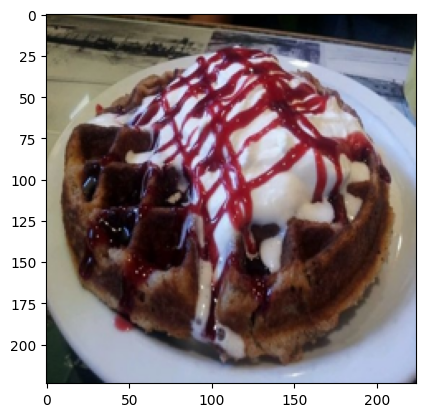

In [25]:
plt.imshow(tensor2label(img1, 0))

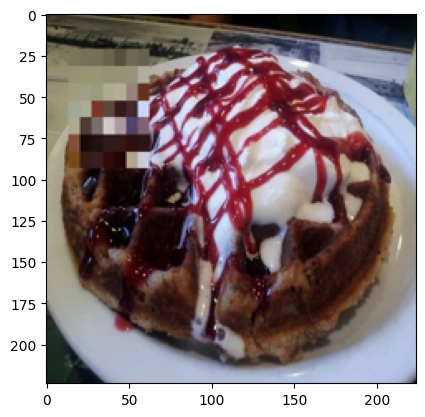

In [26]:
plt.imshow(tensor2label(img2, 0))

In [27]:
with torch.inference_mode():
    result=netG((img1/255).to('cuda')).to('cpu')

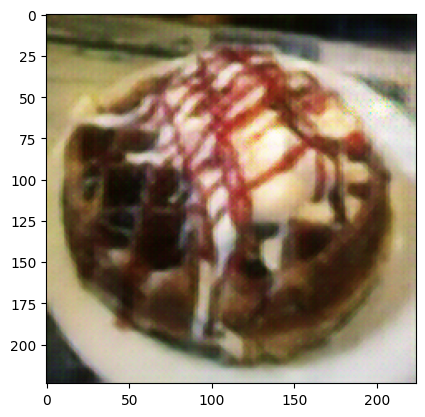

In [28]:
plt.imshow(tensor2im(result))

In [29]:
model = Pix2PixHDModel()
model.initialize()
model = torch.nn.DataParallel(model, device_ids=[0]).cuda()  # Move model to GPU and use DataParallel
optimizer_G, optimizer_D = model.module.optimizer_G, model.module.optimizer_D


GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

In [ ]:
epochs = 200
img_save='./experimental/images_2/'
model_save='./experimental/models_2/'

iter1=next(iter(val_dl))

global_loss_G=100

for i in tqdm.notebook.tqdm(range(epochs)):
    generator_loss=[]
    descriminator_loss=[]

    val_generator_loss=[]
    val_descriminator_loss=[]
    
    for x,y in tqdm.notebook.tqdm(train_dl):
        model.train()
        
        losses, generated = model(Variable(y), Variable(torch.tensor([0])), 
            Variable(x), Variable(torch.tensor([0])), infer=False)

        losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
        loss_dict = dict(zip(model.module.loss_names, losses))

        loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
        loss_G = loss_dict['G_GAN'] + loss_dict.get('G_GAN_Feat',0) + loss_dict.get('G_VGG',0)

        generator_loss.append(loss_G.item())
        descriminator_loss.append(loss_D.item())

        optimizer_G.zero_grad()
        loss_G.backward()          
        optimizer_G.step()

        optimizer_D.zero_grad()
        loss_D.backward()        
        optimizer_D.step() 
        


    for x,y in tqdm.notebook.tqdm(val_dl):
        model.eval()

        with torch.inference_mode():
            losses, generated = model(Variable(y), Variable(torch.tensor([0])), 
                Variable(x), Variable(torch.tensor([0])), infer=False)

        losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
        loss_dict = dict(zip(model.module.loss_names, losses))

        loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
        loss_G = loss_dict['G_GAN'] + loss_dict.get('G_GAN_Feat',0) + loss_dict.get('G_VGG',0)

        val_generator_loss.append(loss_G.item())
        val_descriminator_loss.append(loss_D.item())
        
   

    val_gen_loss=sum(val_generator_loss)/len(val_generator_loss)
    
    print(f"Epoch {i+1}:\nTrain Generator Loss: {sum(generator_loss)/len(generator_loss)}\nTrain Descriminator Loss: {sum(descriminator_loss)/len(descriminator_loss)}\n\nVal Generator Loss: {val_gen_loss}\nVal Descriminator Loss: {sum(val_descriminator_loss)/len(val_descriminator_loss)}\n")

    torch.save(model.state_dict(),f'./{model_save}/model_latest_wt.pt')
    torch.save(model.module.netG.state_dict(),f'./{model_save}/netG_latest_wt.pt')
    
    if(val_gen_loss<global_loss_G):
        global_loss_G=val_gen_loss
        print('\t\t\t\t\t\t---Saving Weights---')
        torch.save(model.state_dict(),f'./{model_save}/model_best_wt.pt')
        torch.save(model.module.netG.state_dict(),f'./{model_save}/netG_best_wt.pt')

    
    
    plt.figure(figsize=(10,15))

    model.eval()

    with torch.inference_mode():
            losses, generated = model(Variable(iter1[1]), Variable(torch.tensor([0])), 
                Variable(iter1[0]), Variable(torch.tensor([0])), infer=False)
    
    count=1
    for j in range(4):
        plt.subplot(4,3,count)
        plt.axis(False)
        plt.imshow(tensor2im(iter1[1][j]))
        plt.subplot(4,3,count+1)
        plt.axis(False)
        plt.imshow(tensor2im(iter1[0][j]))
        plt.subplot(4,3,count+2)
        plt.axis(False)
        plt.imshow(tensor2im(generated[j]))    
        count+=3

    plt.savefig(f'./{img_save}/epoch{i+1}.png')
    plt.close()
    

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1:
Train Generator Loss: 17.40753494644165
Train Descriminator Loss: 0.8813745214939117

Val Generator Loss: 17.235792011260987
Val Descriminator Loss: 0.5096987481117249

						---Saving Weights---


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2:
Train Generator Loss: 16.53723347091675
Train Descriminator Loss: 0.3119683254063129

Val Generator Loss: 18.42412264251709
Val Descriminator Loss: 0.1571219318509102



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3:
Train Generator Loss: 16.611833015441896
Train Descriminator Loss: 0.1468526834398508

Val Generator Loss: 17.587346450805665
Val Descriminator Loss: 0.11422865416109562



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4:
Train Generator Loss: 16.277163604736327
Train Descriminator Loss: 0.1245696110278368

Val Generator Loss: 17.33672617340088
Val Descriminator Loss: 0.09206408485770226



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5:
Train Generator Loss: 16.25827858352661
Train Descriminator Loss: 0.10165436997264624

Val Generator Loss: 16.86773316192627
Val Descriminator Loss: 0.13689628936350345

						---Saving Weights---


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6:
Train Generator Loss: 16.076162612915038
Train Descriminator Loss: 0.16348266848921775

Val Generator Loss: 17.594007442474364
Val Descriminator Loss: 0.053155009001493454



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7:
Train Generator Loss: 16.439865062713622
Train Descriminator Loss: 0.07890125987678766

Val Generator Loss: 17.888774864196776
Val Descriminator Loss: 0.04164465703070164



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8:
Train Generator Loss: 16.188902961730957
Train Descriminator Loss: 0.10346759322285652

Val Generator Loss: 18.22209185409546
Val Descriminator Loss: 0.04397712624818086



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9:
Train Generator Loss: 16.326218799591064
Train Descriminator Loss: 0.062462659891694784

Val Generator Loss: 18.328717098236083
Val Descriminator Loss: 0.04002999188750982



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10:
Train Generator Loss: 15.878450286865235
Train Descriminator Loss: 0.09779413316398859

Val Generator Loss: 18.657872940063477
Val Descriminator Loss: 0.030418131820857525



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11:
Train Generator Loss: 16.233907215118407
Train Descriminator Loss: 0.06592529850825668

Val Generator Loss: 17.56852412033081
Val Descriminator Loss: 0.01913140506669879



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12:
Train Generator Loss: 16.203987365722657
Train Descriminator Loss: 0.06662094201147556

Val Generator Loss: 18.975054512023927
Val Descriminator Loss: 0.13603321504592897



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13:
Train Generator Loss: 16.232890392303467
Train Descriminator Loss: 0.04387774594686925

Val Generator Loss: 18.412268157958984
Val Descriminator Loss: 0.01677734422683716



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14:
Train Generator Loss: 15.891581520080566
Train Descriminator Loss: 0.0254076532907784

Val Generator Loss: 19.24821244049072
Val Descriminator Loss: 0.2932644238471985



  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
with torch.inference_mode():
            generated = netG(iter1[0].to('cuda'))

plt.figure(figsize=(10,15))
    
count=1
for j in range(4):
    plt.subplot(4,3,count)
    plt.axis(False)
    plt.imshow(tensor2im(iter1[1][j]))
    plt.subplot(4,3,count+1)
    plt.axis(False)
    plt.imshow(tensor2im(iter1[0][j]))
    plt.subplot(4,3,count+2)
    plt.axis(False)
    plt.imshow(tensor2im(generated[j]))    
    count+=3

plt.savefig(f'./{img_save}/epoch{i+1}.png')
plt.close()